In [1]:
!pip install --quiet albumentations==2.0.5
!pip install --quiet opencv-python-headless
!pip install --quiet seaborn
!pip install --quiet scikit-learn
!pip install --quiet pillow
!pip install --quiet tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 7.4 MB/s eta 0:00:00:00:01


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as Models
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, average_precision_score
from tqdm import tqdm

In [ ]:
RandomState = 2022484
np.random.seed(RandomState)
random.seed(RandomState)
torch.manual_seed(RandomState)

Device = torch.device("cuda")
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
class DenseNetSequenceMatch(nn.Module):
    def __init__(self, NumClasses=100):
        super().__init__()
        Backbone = Models.densenet121(weights=Models.DenseNet121_Weights.DEFAULT)

        Backbone.features.conv0 = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False
        )
        nn.init.kaiming_normal_(Backbone.features.conv0.weight, mode='fan_out', nonlinearity='relu')

        self.Features = Backbone.features
        self.Classifier = nn.Linear(Backbone.classifier.in_features, NumClasses)

    def forward(self, x):
        feats = self.Features(x)
        relu_out = F.relu(feats, inplace=True)
        pooled = F.adaptive_avg_pool2d(relu_out, (1,1))
        flatten = pooled.view(pooled.size(0), -1)
        logits = self.Classifier(flatten)
        return logits

In [ ]:
def LoadCifar100(DatasetPath):
    Data = []
    ClassToIdx = {}
    IdxToClass = {}
    SuperclassToClass = {}
    IdxToSuperclass = {}

    superFolders = [fld for fld in os.listdir(DatasetPath) if os.path.isdir(os.path.join(DatasetPath, fld))]
    superFolders.sort()

    for sIndex, Superclass in enumerate(superFolders):
        SuperclassToClass[Superclass] = []
        IdxToSuperclass[sIndex] = Superclass
        subClasses = os.listdir(os.path.join(DatasetPath, Superclass))
        subClasses.sort()

        for clsName in subClasses:
            clsPath = os.path.join(DatasetPath, Superclass, clsName)
            if os.path.isdir(clsPath):
                if clsName not in ClassToIdx:
                    cIdx = len(ClassToIdx)
                    ClassToIdx[clsName] = cIdx
                    IdxToClass[cIdx] = clsName
                SuperclassToClass[Superclass].append(ClassToIdx[clsName])

                for imPath in glob(os.path.join(clsPath, "*.png")):
                    imgArray = np.array(Image.open(imPath).convert("RGB"))
                    Data.append((imgArray, ClassToIdx[clsName], sIndex))

    print(f"Dataset loaded with {len(Data)} images across {len(ClassToIdx)} classes and {len(SuperclassToClass)} superclasses.")
    return Data, ClassToIdx, IdxToClass, SuperclassToClass, IdxToSuperclass

In [ ]:
def PlotClassDistribution(Data, IdxToClass):
    classCounts = {}
    for (_, label, _) in Data:
        classCounts[label] = classCounts.get(label, 0) + 1

    sortedLabels = sorted(classCounts.keys())
    counts = [classCounts[lbl] for lbl in sortedLabels]

    plt.figure(figsize=(20, 6))
    names = [IdxToClass[l] for l in sortedLabels]
    sns.barplot(x=names, y=counts)
    plt.title("CIFAR-100 Class Distribution")
    plt.xlabel("Class Name")
    plt.ylabel("Image Count")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def PlotSuperclassDistribution(Data, IdxToSuperclass):
    supCounts = {}
    for (_, _, supIdx) in Data:
        nm = IdxToSuperclass[supIdx]
        supCounts[nm] = supCounts.get(nm, 0) + 1
    sortedKeys = sorted(supCounts.keys())
    cVals = [supCounts[k] for k in sortedKeys]

    plt.figure(figsize=(12, 6))
    sns.barplot(x=sortedKeys, y=cVals)
    plt.title("CIFAR-100 Superclass Distribution")
    plt.xlabel("Superclass Name")
    plt.ylabel("Image Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def DisplayRandomImages(Data, IdxToClass, IdxToSuperclass, NumImages=20):
    subset = random.sample(Data, NumImages)
    fig, Axes = plt.subplots(4, 5, figsize=(12, 10))
    for ax, (imgArr, lbl, sCls) in zip(Axes.flat, subset):
        ax.imshow(imgArr)
        ax.axis("off")
        ax.set_title(f"{IdxToClass[lbl]}\n({IdxToSuperclass[sCls]})", fontsize=8)
    plt.suptitle("Random Sample Images from CIFAR-100")
    plt.tight_layout()
    plt.show()

def DisplayAugmentedImages(Data, NumImages=10):
    wTrans = A.Compose([
        A.RandomCrop(32, 32, p=1.0),
        A.HorizontalFlip(p=1.0)
    ])
    sTrans = A.Compose([
        A.Perspective(scale=(0.05, 0.1), p=1.0),
        A.Affine(shear=15, p=1.0),
        A.OneOf([
            A.GaussianBlur(blur_limit=(3,7), p=1.0),
            A.RandomBrightnessContrast(p=1.0),
            A.RandomGamma(p=1.0),
        ], p=1.0)
    ])

    subset = random.sample(Data, NumImages)
    fig, Axes = plt.subplots(3, NumImages, figsize=(15,10))
    for i, (imgArr, _, _) in enumerate(subset):
        Axes[0, i].imshow(imgArr)
        Axes[0, i].axis("off")
        Axes[0, i].set_title("Original", fontsize=8)

        wA = wTrans(image=imgArr)['image']
        Axes[1, i].imshow(wA)
        Axes[1, i].axis("off")
        Axes[1, i].set_title("Weak", fontsize=8)

        sA = sTrans(image=imgArr)['image']
        Axes[2, i].imshow(sA)
        Axes[2, i].axis("off")
        Axes[2, i].set_title("Strong", fontsize=8)

    plt.suptitle("Demonstration of Image Augmentations")
    plt.tight_layout()
    plt.show()

In [ ]:
def FixedCountSplit(Data, NumPerClass):
    classDict = {}
    for item in Data:
        _, lbl, _ = item
        if lbl not in classDict:
            classDict[lbl] = []
        classDict[lbl].append(item)

    labeled = []
    unlabeled = []
    for lbl, arr in classDict.items():
        random.shuffle(arr)
        if len(arr) > NumPerClass:
            labeled.extend(arr[:NumPerClass])
            unlabeled.extend(arr[NumPerClass:])
        else:
            labeled.extend(arr)
    return labeled, unlabeled

def SplitDataFixedCount(Data, NumPerClass):
    TrainData, TempData = train_test_split(
        Data, train_size=0.8, stratify=[x[1] for x in Data], random_state=RandomState
    )
    ValData, TestData = train_test_split(
        TempData, train_size=0.5, stratify=[x[1] for x in TempData], random_state=RandomState
    )

    LabeledData, UnlabeledData = FixedCountSplit(TrainData, NumPerClass)

    print(f"\n[Data Split] Fixed Count: {NumPerClass} labeled samples per class")
    print(f"Labeled Training Data: {len(LabeledData)} samples")
    print(f"Unlabeled Training Data: {len(UnlabeledData)} samples")
    print(f"Validation Data: {len(ValData)} samples")
    print(f"Test Data:  {len(TestData)} samples")
    return LabeledData, UnlabeledData, ValData, TestData

In [ ]:
class Cifar100SequenceMatchDataset(Dataset):
    def __init__(self, data, transformOrig, transformWeak, transformMed, transformStr, isUnlabeled=False):
        super().__init__()
        self.data = data
        self.transformOrig = transformOrig
        self.transformWeak = transformWeak
        self.transformMed = transformMed
        self.transformStr = transformStr
        self.isUnlabeled = isUnlabeled

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        imgArr, lbl, _ = self.data[idx]
        if self.isUnlabeled:
            lbl = -1

        oImg = self.transformOrig(image=imgArr)['image']
        wImg = self.transformWeak(image=imgArr)['image']
        mImg = self.transformMed(image=imgArr)['image']
        sImg = self.transformStr(image=imgArr)['image']

        return {
            "Original": oImg,
            "Weak": wImg,
            "Medium": mImg,
            "Strong": sImg,
            "Label": lbl
        }

In [ ]:
class Cifar100TestDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        imgArr, lbl, _ = self.data[idx]
        out = self.transform(image=imgArr)['image']
        return out, lbl

In [ ]:
def main():
    mean_vals = (0.5, 0.5, 0.5)
    std_vals  = (0.5, 0.5, 0.5)

    transformOriginal = A.Compose([
        A.Resize(32,32),
        A.Normalize(mean=mean_vals, std=std_vals, max_pixel_value=255.0),
        ToTensorV2()
    ])

    transformWeak = A.Compose([
        A.Resize(32, 32),
        A.RandomCrop(width=32, height=32, p=1.0),
        A.HorizontalFlip(p=1.0),
        A.Normalize(mean=mean_vals, std=std_vals, max_pixel_value=255.0),
        ToTensorV2()
    ])

    transformMedium = A.Compose([
        A.Resize(32, 32),
        A.Affine(rotate=(-10, 10), scale=(0.9, 1.1), shear=0, p=1.0),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=1.0),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=1.0),
        A.Normalize(mean=mean_vals, std=std_vals, max_pixel_value=255.0),
        ToTensorV2()
    ])

    transformStrong = A.Compose([
        A.Resize(32, 32),
        A.Perspective(scale=(0.05, 0.1), p=1.0),
        A.Affine(shear=15, scale=1.0, translate_percent=0.0, rotate=0, p=1.0),
        A.OneOf([
            A.GaussianBlur(blur_limit=(3, 7), p=1.0),
            A.RandomBrightnessContrast(p=1.0),
            A.RandomGamma(p=1.0)
        ], p=1.0),
        A.Normalize(mean=mean_vals, std=std_vals, max_pixel_value=255.0),
        ToTensorV2()
    ])

    dataset_path = "/kaggle/input/cifar-100/cifar_100"
    data, ClassToIdx, IdxToClass, SuperToClass, IdxToSuper = LoadCifar100(dataset_path)

    PlotClassDistribution(data, IdxToClass)
    PlotSuperclassDistribution(data, IdxToSuper)
    DisplayRandomImages(data, IdxToClass, IdxToSuper, NumImages=20)
    DisplayAugmentedImages(data, NumImages=10)

    fixedCounts = [75, 175, 260, 360]
    Eps = 1e-8
    Tau = 0.95
    LambdaU = 0.8
    NumEpochs = 20

    ResultsDict = {}
    AllMetricsDict = {}
    
    for fixedC in fixedCounts:
        print(f"\n=== Running SequenceMatch with {fixedC} labeled samples per class ===")
        labeledData, unlabeledData, valData, testData = SplitDataFixedCount(data, fixedC)

        trainLabeledDS = Cifar100SequenceMatchDataset(
            data=labeledData,
            transformOrig=transformOriginal,
            transformWeak=transformWeak,
            transformMed=transformMedium,
            transformStr=transformStrong,
            isUnlabeled=False
        )
        trainUnlabeledDS = Cifar100SequenceMatchDataset(
            data=unlabeledData,
            transformOrig=transformOriginal,
            transformWeak=transformWeak,
            transformMed=transformMedium,
            transformStr=transformStrong,
            isUnlabeled=True
        )

        valDS = Cifar100TestDataset(valData, transformOriginal)
        testDS= Cifar100TestDataset(testData, transformOriginal)

        BATCH_SIZE = 256
        labLoader = DataLoader(trainLabeledDS, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
        unlabLoader= DataLoader(trainUnlabeledDS, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

        valLoader = DataLoader(valDS, batch_size=256, shuffle=False, num_workers=4)
        testLoader= DataLoader(testDS,batch_size=256, shuffle=False, num_workers=4)

        model = DenseNetSequenceMatch(NumClasses=100).to(Device)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NumEpochs)

        TrainLossList = []
        TrainSupLossList = []
        TrainUnsupLossList = []
        TrainAccList = []
        ValLossList = []
        ValAccList = []

        for epoch in range(NumEpochs):
            model.train()
            totalLoss = 0.0
            supLossSum = 0.0
            unsupLossSum = 0.0
            correctSup = 0
            totalSup = 0
            nBatches = 0

            unlabIter = iter(unlabLoader)

            for lbBatch in tqdm(labLoader, desc=f"Epoch {epoch+1}/{NumEpochs}", leave=False):
                try:
                    ubBatch = next(unlabIter)
                except StopIteration:
                    unlabIter = iter(unlabLoader)
                    ubBatch = next(unlabIter)

                lw = lbBatch["Weak"].to(Device)
                labs = lbBatch["Label"].to(Device).long()

                outL = model(lw)
                supLoss = F.cross_entropy(outL, labs)

                predsL = torch.argmax(outL, dim=1)
                correctSup += (predsL == labs).sum().item()
                totalSup += labs.size(0)

                wU = ubBatch["Weak"].to(Device)
                mU = ubBatch["Medium"].to(Device)
                sU = ubBatch["Strong"].to(Device)

                with torch.no_grad():
                    outWeak = model(wU)
                    distWeak = F.softmax(outWeak, dim=1)

                maxProb, hardLabel = torch.max(distWeak, dim=1)
                highConfMask = (maxProb >= Tau).float()

                outMed = model(mU)
                distMed = F.softmax(outMed, dim=1)

                outStr = model(sU)
                distStr = F.softmax(outStr, dim=1)

                T=0.5
                sharpenedW = distWeak ** (1.0 / T)
                sharpenedW = sharpenedW / (sharpenedW.sum(dim=1, keepdim=True) + Eps)

                hardCE = F.cross_entropy(outStr, hardLabel, reduction='none')
                logStr = F.log_softmax(outStr, dim=1)
                softCE = -(sharpenedW * logStr).sum(dim=1)

                unsupCE = highConfMask * hardCE + (1.0 - highConfMask) * softCE
                unsupCE = unsupCE.mean()

                def kl_divergence(p, q):
                    return (p * (p.add(Eps).log() - q.add(Eps).log())).sum(dim=1)

                DistWeak_sharp = sharpenedW.detach()
                KL_w_m = highConfMask * kl_divergence(DistWeak_sharp, distMed)
                KL_m_s = highConfMask * kl_divergence(distMed, distStr)
                KL_w_s = highConfMask * kl_divergence(DistWeak_sharp, distStr)

                KL_w_m = KL_w_m.mean()
                KL_m_s = KL_m_s.mean()
                KL_w_s = KL_w_s.mean()

                unsupKL = KL_w_m + KL_m_s + KL_w_s
                klWeighted = 0.1 * unsupKL
                unsupLoss = unsupCE + klWeighted
                unsupLossWeighted = LambdaU * unsupLoss
                totalBatchLoss = supLoss + unsupLossWeighted

                optimizer.zero_grad()
                totalBatchLoss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
                optimizer.step()

                totalLoss += totalBatchLoss.item()
                supLossSum += supLoss.item()
                unsupLossSum += unsupLoss.item()
                nBatches += 1

            avgTot = totalLoss / nBatches
            avgSup = supLossSum / nBatches
            avgUnsup= unsupLossSum / nBatches
            trainAcc= correctSup / (totalSup + 1e-8)

            TrainLossList.append(avgTot)
            TrainSupLossList.append(avgSup)
            TrainUnsupLossList.append(avgUnsup)
            TrainAccList.append(trainAcc)

            model.eval()
            valLossSum = 0.0
            valB = 0
            valPreds = []
            valLabs  = []
            with torch.no_grad():
                for ims, labs_ in valLoader:
                    ims= ims.to(Device)
                    labs_= labs_.to(Device).long()
                    logitsVal= model(ims)
                    lossVal = F.cross_entropy(logitsVal, labs_)
                    valLossSum += lossVal.item()
                    valB += 1
                    preds_ = torch.argmax(logitsVal, dim=1)
                    valPreds.extend(preds_.cpu().numpy())
                    valLabs.extend(labs_.cpu().numpy())
            avgValLoss = valLossSum / valB
            valAcc     = accuracy_score(valLabs, valPreds)

            ValLossList.append(avgValLoss)
            ValAccList.append(valAcc)

            print(f"Epoch[{epoch+1}/{NumEpochs}] FC={fixedC} "
                  f"TrainLoss={avgTot:.4f}, Sup={avgSup:.4f}, Unsup={avgUnsup:.4f}, TrainAcc={trainAcc*100:.2f}% "
                  f"ValLoss={avgValLoss:.4f}, ValAcc={valAcc*100:.2f}%")

            scheduler.step()

        outModelName = f"SequenceMatch_CIFAR100_{fixedC}_labeled.pth"
        torch.save(model.state_dict(), outModelName)
        print(f"Saved SequenceMatch model => {outModelName}")

        model.eval()
        testPreds = []
        testLabs  = []
        testProbs = []
        with torch.no_grad():
            for ims, labs_ in testLoader:
                ims = ims.to(Device)
                labs_= labs_.to(Device).long()
                outTe= model(ims)
                pTe= F.softmax(outTe, dim=1)
                prd= torch.argmax(outTe, dim=1)
                testPreds.extend(prd.cpu().numpy())
                testLabs.extend(labs_.cpu().numpy())
                testProbs.extend(pTe.cpu().numpy())

        testAcc= accuracy_score(testLabs, testPreds)
        oneHot = np.eye(100)[np.array(testLabs)]
        rocAuc = roc_auc_score(oneHot, np.array(testProbs), multi_class="ovr")
        avgPrec= average_precision_score(oneHot, np.array(testProbs), average="macro")

        print(f"\n[Test Evaluation] FC={fixedC} => "
              f"TestAcc={testAcc*100:.2f}%, ROC AUC={rocAuc:.4f}, AvgPrecision={avgPrec:.4f}")

        targetNames = [IdxToClass[i] for i in range(len(IdxToClass))]
        print(classification_report(testLabs, testPreds, target_names=targetNames, zero_division=0))

        ResultsDict[fixedC]= testAcc
        AllMetricsDict[fixedC] = {
            "TrainLoss": TrainLossList,
            "TrainSupLoss": TrainSupLossList,
            "TrainUnsupLoss": TrainUnsupLossList,
            "TrainAcc": TrainAccList,
            "ValLoss": ValLossList,
            "ValAcc": ValAccList,
            "TestAcc": testAcc
        }

        ERange = range(1, len(TrainLossList)+1)

        plt.figure(figsize=(8,5))
        plt.plot(ERange, AllMetricsDict[fixedC]["TrainLoss"], label="Total Train Loss", marker="o")
        plt.plot(ERange, AllMetricsDict[fixedC]["TrainSupLoss"], label="Supervised Loss", marker="o")
        plt.plot(ERange, AllMetricsDict[fixedC]["TrainUnsupLoss"], label="Unsupervised Loss", marker="o")
        plt.title(f"Training Loss Curves (FC={fixedC})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8,5))
        plt.plot(ERange, AllMetricsDict[fixedC]["TrainAcc"], label="Train Accuracy", marker="o")
        plt.title(f"Training Accuracy (FC={fixedC})")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8,5))
        plt.plot(ERange, AllMetricsDict[fixedC]["ValLoss"], label="Validation Loss", marker="o", color="red")
        plt.title(f"Validation Loss (FC={fixedC})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8,5))
        plt.plot(ERange, [v*100 for v in AllMetricsDict[fixedC]["ValAcc"]], label="Val Accuracy (%)", marker="o", color="green")
        plt.title(f"Validation Accuracy (FC={fixedC})")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8,5))
        plt.plot(ERange, AllMetricsDict[fixedC]["TrainLoss"], label="Train Loss", marker="o")
        plt.plot(ERange, AllMetricsDict[fixedC]["ValLoss"], label="Val Loss", marker="o", color="red")
        plt.title(f"Train Vs. Val Loss (FC={fixedC})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.tight_layout()
        plt.show()

        print(f"--- Finished plotting for {fixedC} labeled/class ---")

    bestCount = max(ResultsDict, key=ResultsDict.get)
    print(f"\n[Test Summary] Best run => {bestCount} labeled/class with TestAcc={ResultsDict[bestCount]*100:.2f}%")

Dataset loaded with 60000 images across 100 classes and 20 superclasses.


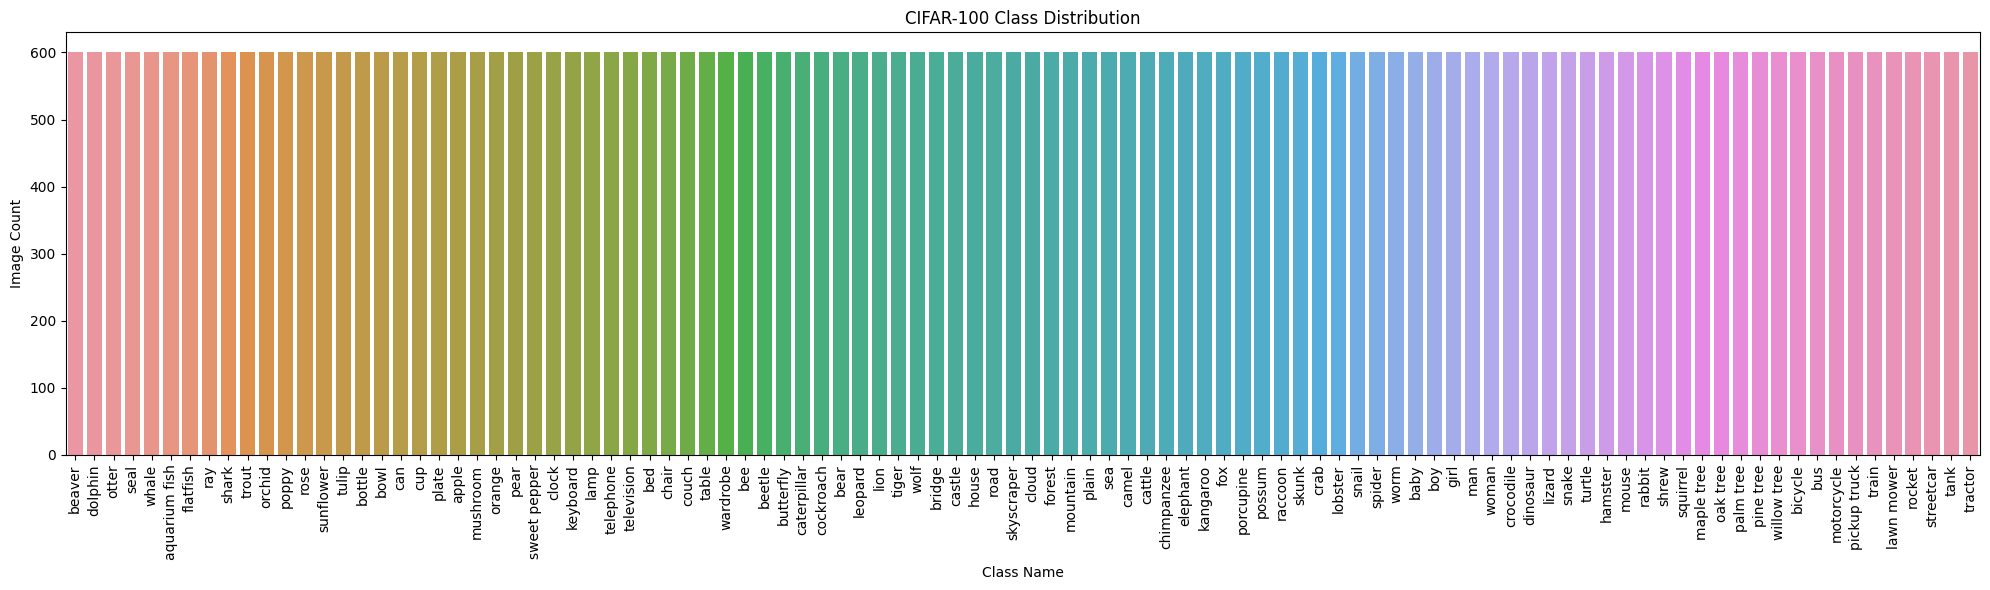

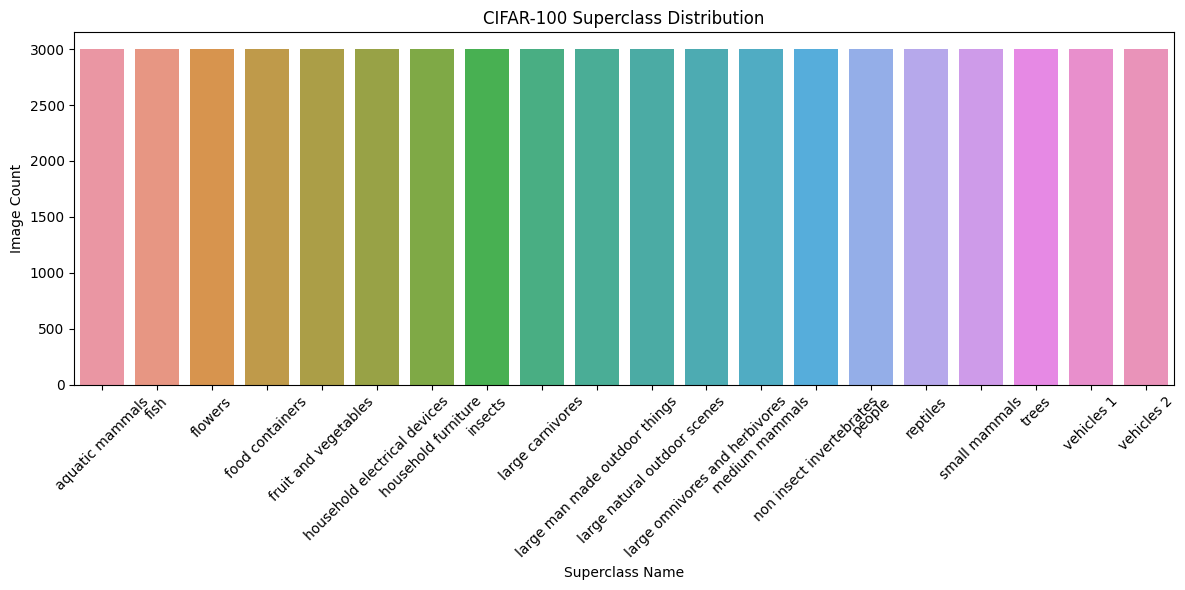

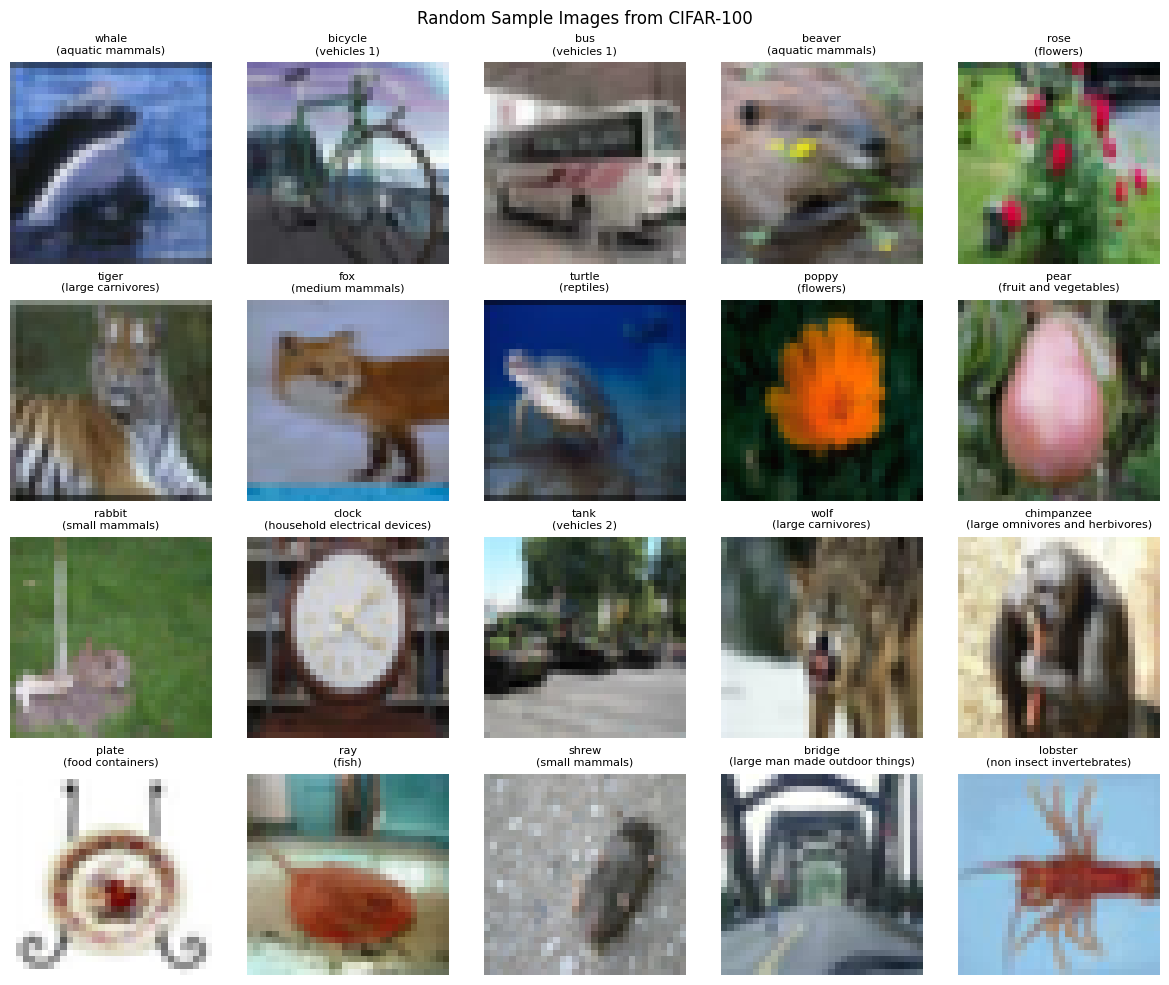

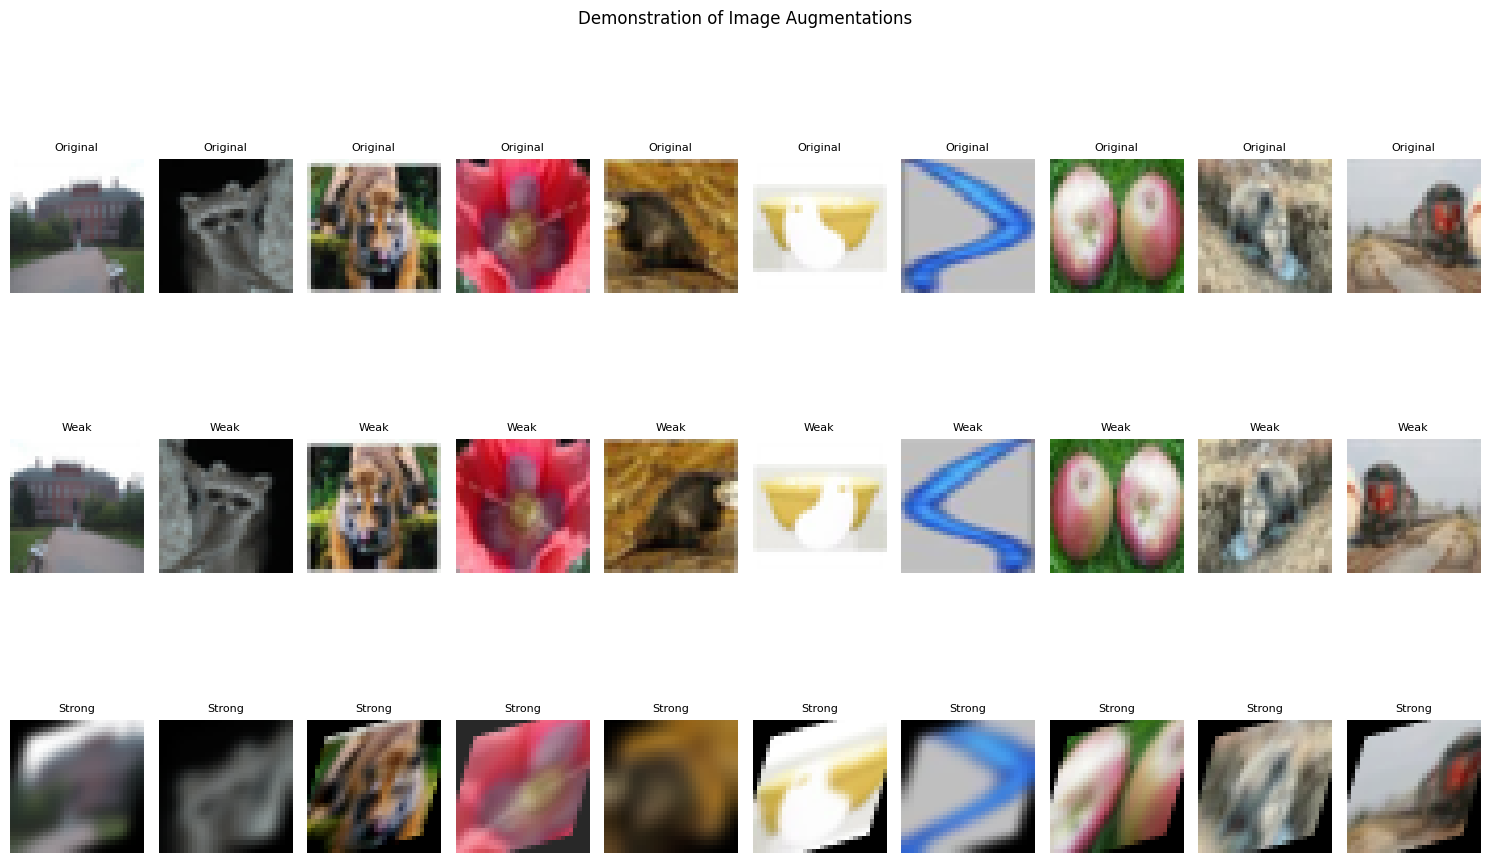


=== Running SequenceMatch with 75 labeled samples per class ===

[Data Split] Fixed Count: 75 labeled samples per class
Labeled Training Data: 7500 samples
Unlabeled Training Data: 40500 samples
Validation Data: 6000 samples
Test Data:  6000 samples


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 176MB/s]


Epoch[1/20] FC=75 TrainLoss=7.8467, Sup=4.7066, Unsup=3.9251, TrainAcc=1.63% ValLoss=4.8436, ValAcc=2.98%


Epoch[2/20] FC=75 TrainLoss=5.3706, Sup=4.2475, Unsup=1.4039, TrainAcc=5.49% ValLoss=4.0127, ValAcc=9.13%


Epoch[3/20] FC=75 TrainLoss=5.4732, Sup=3.1916, Unsup=2.8520, TrainAcc=20.87% ValLoss=3.3372, ValAcc=20.15%


Epoch[4/20] FC=75 TrainLoss=4.7595, Sup=2.4285, Unsup=2.9137, TrainAcc=38.55% ValLoss=3.0600, ValAcc=25.83%


Epoch[5/20] FC=75 TrainLoss=3.9898, Sup=1.7897, Unsup=2.7501, TrainAcc=55.23% ValLoss=2.8659, ValAcc=29.23%


Epoch[6/20] FC=75 TrainLoss=3.4307, Sup=1.3009, Unsup=2.6622, TrainAcc=69.73% ValLoss=2.8062, ValAcc=31.23%


Epoch[7/20] FC=75 TrainLoss=2.9899, Sup=0.9073, Unsup=2.6032, TrainAcc=82.00% ValLoss=2.7938, ValAcc=31.95%


Epoch[8/20] FC=75 TrainLoss=2.6673, Sup=0.6286, Unsup=2.5483, TrainAcc=90.43% ValLoss=2.8052, ValAcc=32.17%


Epoch[9/20] FC=75 TrainLoss=2.4607, Sup=0.4533, Unsup=2.5092, TrainAcc=94.99% ValLoss=2.7675, ValAcc=33.78%


Epoch[10/20] FC=75 TrainLoss=2.3161, Sup=0.3314, Unsup=2.4809, TrainAcc=97.49% ValLoss=2.7152, ValAcc=34.92%


Epoch[11/20] FC=75 TrainLoss=2.2165, Sup=0.2539, Unsup=2.4531, TrainAcc=98.83% ValLoss=2.7191, ValAcc=34.17%


Epoch[12/20] FC=75 TrainLoss=2.1224, Sup=0.2000, Unsup=2.4030, TrainAcc=99.40% ValLoss=2.7203, ValAcc=34.58%


Epoch[13/20] FC=75 TrainLoss=2.0684, Sup=0.1658, Unsup=2.3782, TrainAcc=99.76% ValLoss=2.7291, ValAcc=34.95%


Epoch[14/20] FC=75 TrainLoss=1.9962, Sup=0.1440, Unsup=2.3152, TrainAcc=99.85% ValLoss=2.6971, ValAcc=35.03%


Epoch[15/20] FC=75 TrainLoss=1.9747, Sup=0.1241, Unsup=2.3132, TrainAcc=99.96% ValLoss=2.7052, ValAcc=34.73%


Epoch[16/20] FC=75 TrainLoss=1.9410, Sup=0.1156, Unsup=2.2817, TrainAcc=99.99% ValLoss=2.6975, ValAcc=34.82%


Epoch[17/20] FC=75 TrainLoss=1.9059, Sup=0.1005, Unsup=2.2568, TrainAcc=99.97% ValLoss=2.6973, ValAcc=35.05%


Epoch[18/20] FC=75 TrainLoss=1.8942, Sup=0.0964, Unsup=2.2473, TrainAcc=99.99% ValLoss=2.6977, ValAcc=35.43%


Epoch[19/20] FC=75 TrainLoss=1.8922, Sup=0.0920, Unsup=2.2502, TrainAcc=100.00% ValLoss=2.6909, ValAcc=35.95%


Epoch[20/20] FC=75 TrainLoss=1.8729, Sup=0.0907, Unsup=2.2277, TrainAcc=100.00% ValLoss=2.6811, ValAcc=35.87%
Saved SequenceMatch model => SequenceMatch_CIFAR100_75_labeled.pth

[Test Evaluation] FC=75 => TestAcc=36.37%, ROC AUC=0.9326, AvgPrecision=0.3636
               precision    recall  f1-score   support

       beaver       0.11      0.05      0.07        60
      dolphin       0.26      0.42      0.32        60
        otter       0.19      0.05      0.08        60
         seal       0.22      0.08      0.12        60
        whale       0.33      0.33      0.33        60
aquarium fish       0.49      0.35      0.41        60
     flatfish       0.23      0.12      0.16        60
          ray       0.42      0.47      0.44        60
        shark       0.39      0.18      0.25        60
        trout       0.53      0.42      0.47        60
       orchid       0.45      0.40      0.42        60
        poppy       0.52      0.50      0.51        60
         rose       0.56   

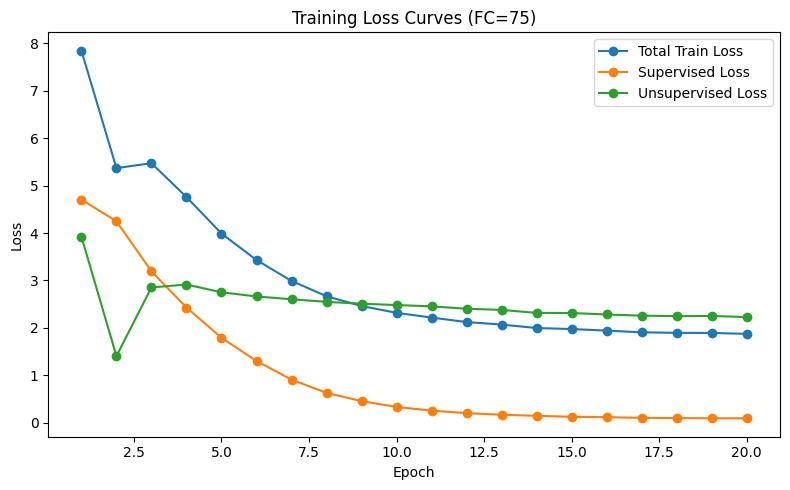

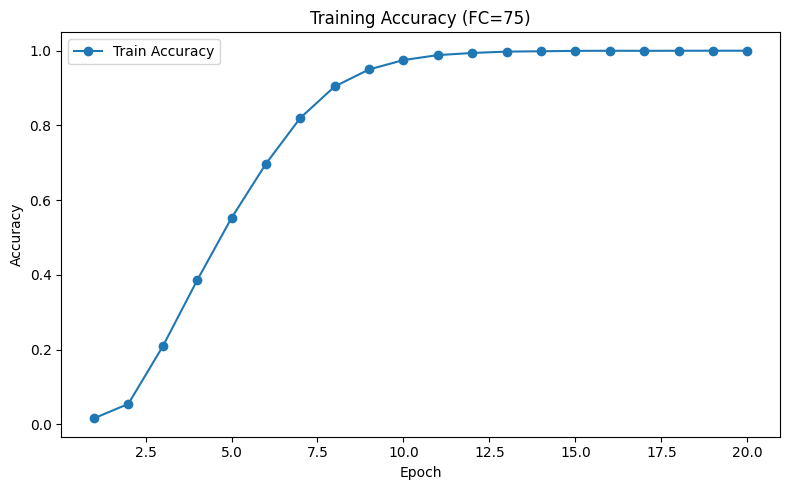

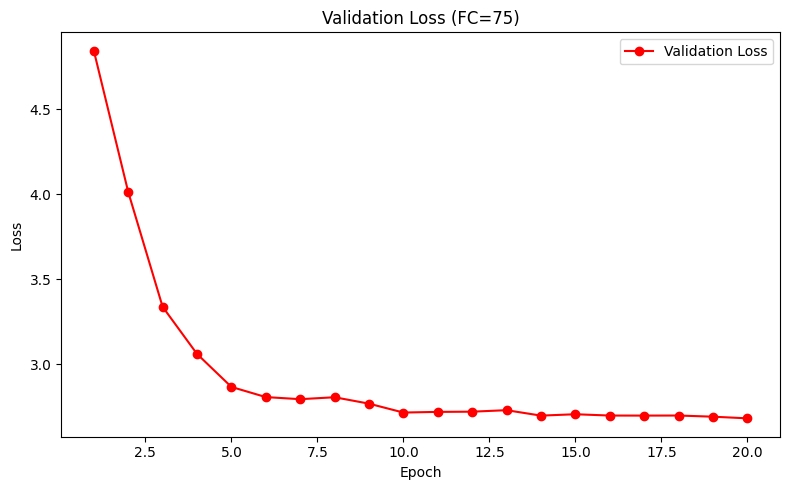

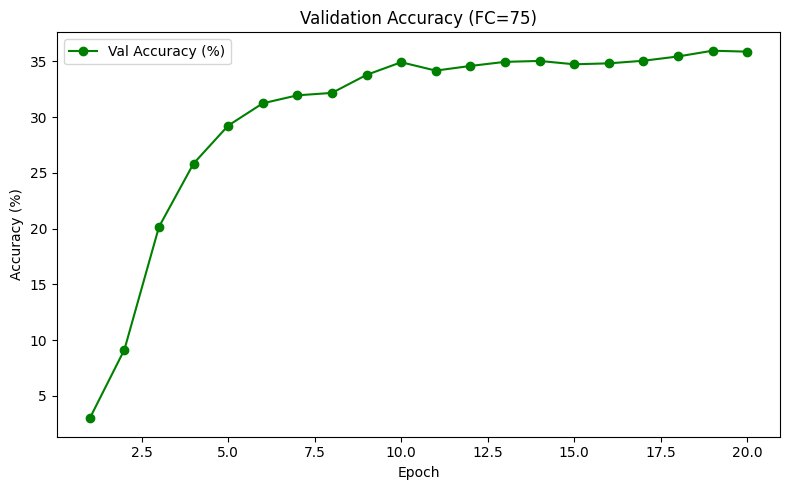

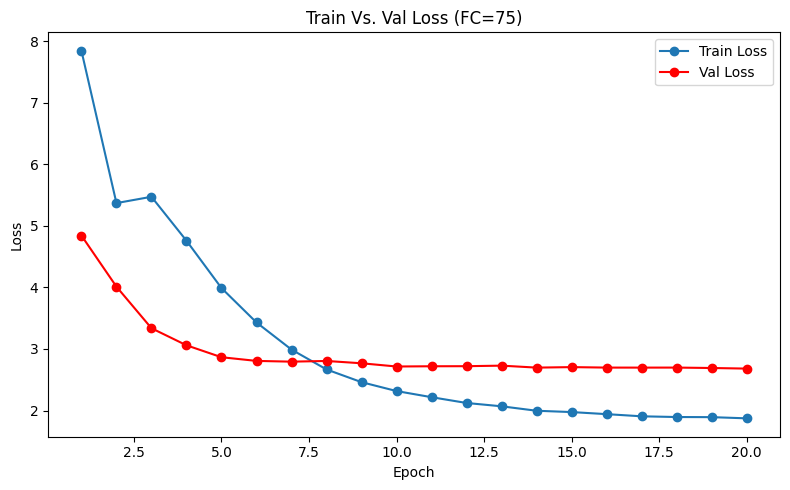

--- Finished plotting for 75 labeled/class ---

=== Running SequenceMatch with 175 labeled samples per class ===

[Data Split] Fixed Count: 175 labeled samples per class
Labeled Training Data: 17500 samples
Unlabeled Training Data: 30500 samples
Validation Data: 6000 samples
Test Data:  6000 samples


Epoch[1/20] FC=175 TrainLoss=6.5426, Sup=4.5159, Unsup=2.5334, TrainAcc=4.04% ValLoss=3.7172, ValAcc=14.57%


Epoch[2/20] FC=175 TrainLoss=5.2594, Sup=3.1630, Unsup=2.6206, TrainAcc=22.46% ValLoss=2.8177, ValAcc=30.63%


Epoch[3/20] FC=175 TrainLoss=4.1345, Sup=2.2211, Unsup=2.3918, TrainAcc=41.57% ValLoss=2.4573, ValAcc=36.13%


Epoch[4/20] FC=175 TrainLoss=3.3747, Sup=1.6402, Unsup=2.1681, TrainAcc=54.93% ValLoss=2.1983, ValAcc=42.85%


Epoch[5/20] FC=175 TrainLoss=2.8264, Sup=1.2029, Unsup=2.0294, TrainAcc=66.62% ValLoss=2.0142, ValAcc=46.35%


Epoch[6/20] FC=175 TrainLoss=2.4313, Sup=0.8720, Unsup=1.9492, TrainAcc=76.54% ValLoss=1.9442, ValAcc=49.55%


Epoch[7/20] FC=175 TrainLoss=2.1286, Sup=0.6240, Unsup=1.8807, TrainAcc=84.17% ValLoss=1.9478, ValAcc=48.87%


Epoch[8/20] FC=175 TrainLoss=1.9080, Sup=0.4432, Unsup=1.8310, TrainAcc=90.73% ValLoss=1.8954, ValAcc=50.80%


Epoch[9/20] FC=175 TrainLoss=1.7606, Sup=0.3164, Unsup=1.8052, TrainAcc=94.82% ValLoss=1.9439, ValAcc=49.78%


Epoch[10/20] FC=175 TrainLoss=1.6546, Sup=0.2359, Unsup=1.7734, TrainAcc=97.00% ValLoss=1.9018, ValAcc=50.70%


Epoch[11/20] FC=175 TrainLoss=1.5532, Sup=0.1818, Unsup=1.7143, TrainAcc=98.32% ValLoss=1.8857, ValAcc=51.38%


Epoch[12/20] FC=175 TrainLoss=1.4604, Sup=0.1431, Unsup=1.6467, TrainAcc=99.20% ValLoss=1.9053, ValAcc=52.00%


Epoch[13/20] FC=175 TrainLoss=1.3830, Sup=0.1142, Unsup=1.5859, TrainAcc=99.60% ValLoss=1.8857, ValAcc=52.70%


Epoch[14/20] FC=175 TrainLoss=1.3246, Sup=0.0929, Unsup=1.5396, TrainAcc=99.78% ValLoss=1.8560, ValAcc=53.68%


Epoch[15/20] FC=175 TrainLoss=1.2708, Sup=0.0805, Unsup=1.4880, TrainAcc=99.89% ValLoss=1.8803, ValAcc=52.83%


Epoch[16/20] FC=175 TrainLoss=1.2494, Sup=0.0697, Unsup=1.4746, TrainAcc=99.94% ValLoss=1.8560, ValAcc=53.45%


Epoch[17/20] FC=175 TrainLoss=1.2130, Sup=0.0619, Unsup=1.4388, TrainAcc=99.95% ValLoss=1.8517, ValAcc=53.80%


Epoch[18/20] FC=175 TrainLoss=1.1910, Sup=0.0572, Unsup=1.4172, TrainAcc=99.95% ValLoss=1.8431, ValAcc=53.80%


Epoch[19/20] FC=175 TrainLoss=1.1831, Sup=0.0553, Unsup=1.4098, TrainAcc=99.97% ValLoss=1.8508, ValAcc=53.95%


Epoch[20/20] FC=175 TrainLoss=1.1651, Sup=0.0541, Unsup=1.3888, TrainAcc=99.96% ValLoss=1.8511, ValAcc=54.05%
Saved SequenceMatch model => SequenceMatch_CIFAR100_175_labeled.pth

[Test Evaluation] FC=175 => TestAcc=52.60%, ROC AUC=0.9714, AvgPrecision=0.5623
               precision    recall  f1-score   support

       beaver       0.23      0.15      0.18        60
      dolphin       0.39      0.43      0.41        60
        otter       0.20      0.15      0.17        60
         seal       0.33      0.27      0.29        60
        whale       0.42      0.65      0.51        60
aquarium fish       0.73      0.58      0.65        60
     flatfish       0.38      0.32      0.35        60
          ray       0.65      0.55      0.59        60
        shark       0.52      0.42      0.46        60
        trout       0.53      0.58      0.56        60
       orchid       0.58      0.65      0.61        60
        poppy       0.58      0.57      0.57        60
         rose       0.59 

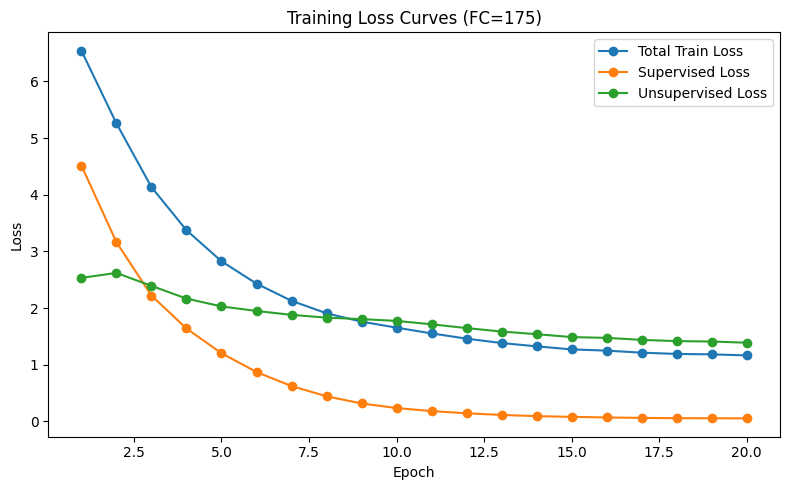

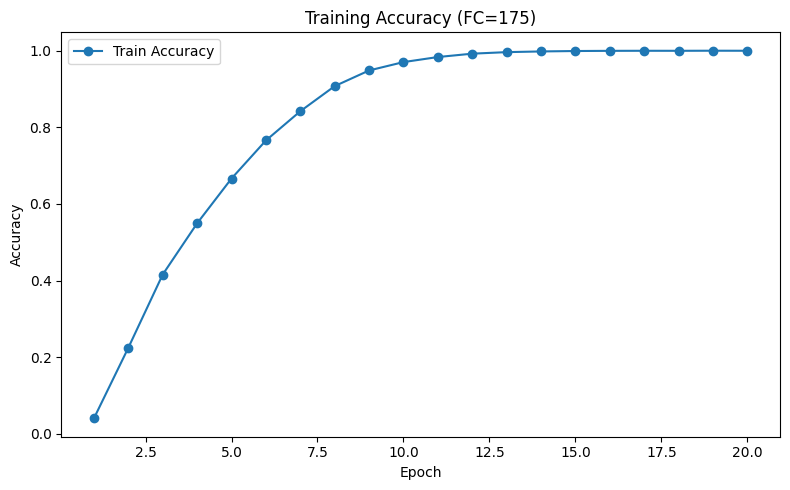

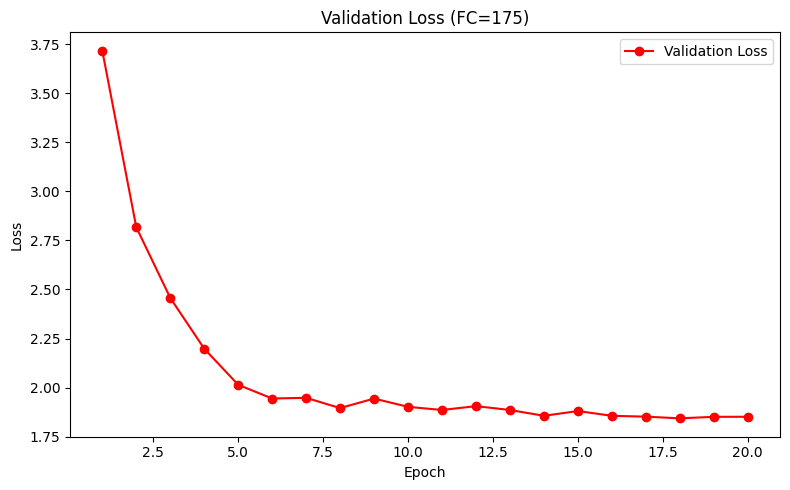

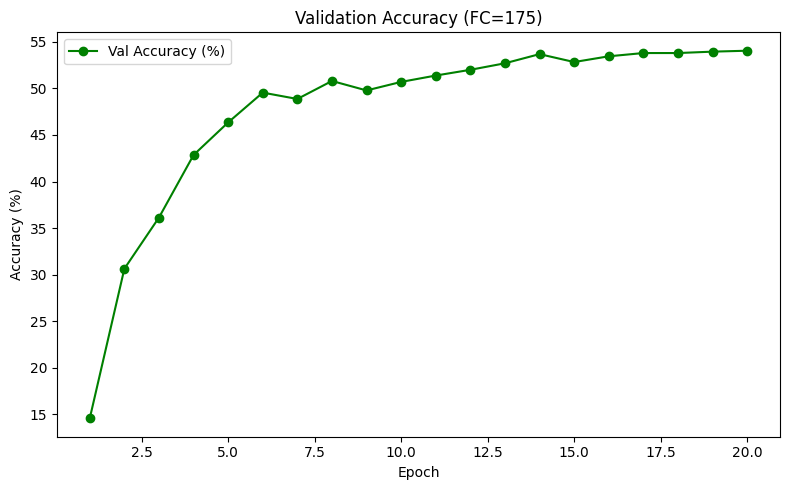

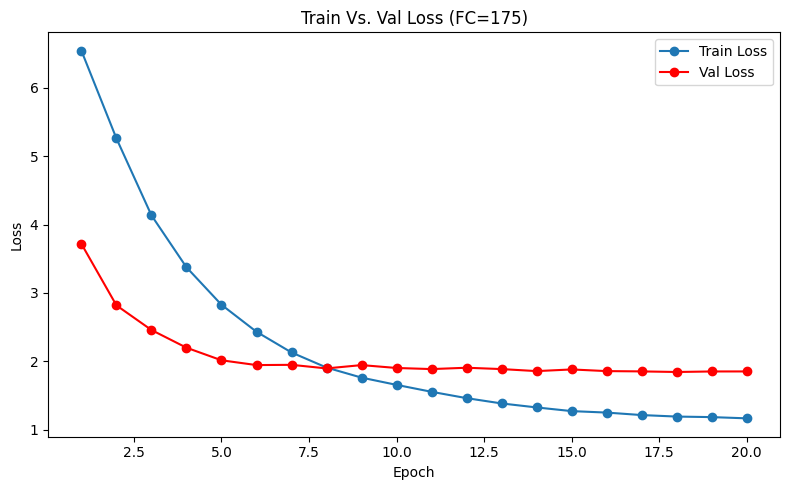

--- Finished plotting for 175 labeled/class ---

=== Running SequenceMatch with 260 labeled samples per class ===

[Data Split] Fixed Count: 260 labeled samples per class
Labeled Training Data: 26000 samples
Unlabeled Training Data: 22000 samples
Validation Data: 6000 samples
Test Data:  6000 samples


Epoch[1/20] FC=260 TrainLoss=6.4883, Sup=4.0895, Unsup=2.9986, TrainAcc=8.88% ValLoss=3.1876, ValAcc=21.92%


Epoch[2/20] FC=260 TrainLoss=4.3911, Sup=2.4600, Unsup=2.4138, TrainAcc=36.05% ValLoss=2.2577, ValAcc=41.33%


Epoch[3/20] FC=260 TrainLoss=3.2671, Sup=1.6854, Unsup=1.9771, TrainAcc=53.38% ValLoss=1.9408, ValAcc=48.70%


Epoch[4/20] FC=260 TrainLoss=2.6553, Sup=1.2202, Unsup=1.7938, TrainAcc=64.98% ValLoss=1.7614, ValAcc=51.85%


Epoch[5/20] FC=260 TrainLoss=2.2137, Sup=0.8928, Unsup=1.6511, TrainAcc=74.21% ValLoss=1.6741, ValAcc=54.98%


Epoch[6/20] FC=260 TrainLoss=1.8949, Sup=0.6399, Unsup=1.5688, TrainAcc=82.13% ValLoss=1.6384, ValAcc=56.45%


Epoch[7/20] FC=260 TrainLoss=1.6288, Sup=0.4523, Unsup=1.4705, TrainAcc=88.38% ValLoss=1.6397, ValAcc=56.93%


Epoch[8/20] FC=260 TrainLoss=1.4566, Sup=0.3210, Unsup=1.4196, TrainAcc=92.80% ValLoss=1.6272, ValAcc=58.30%


Epoch[9/20] FC=260 TrainLoss=1.3267, Sup=0.2355, Unsup=1.3639, TrainAcc=95.42% ValLoss=1.5925, ValAcc=58.72%


Epoch[10/20] FC=260 TrainLoss=1.2012, Sup=0.1728, Unsup=1.2855, TrainAcc=97.56% ValLoss=1.5940, ValAcc=59.10%


Epoch[11/20] FC=260 TrainLoss=1.0986, Sup=0.1324, Unsup=1.2077, TrainAcc=98.53% ValLoss=1.6013, ValAcc=59.68%


Epoch[12/20] FC=260 TrainLoss=1.0318, Sup=0.1034, Unsup=1.1605, TrainAcc=99.17% ValLoss=1.5724, ValAcc=60.33%


Epoch[13/20] FC=260 TrainLoss=0.9586, Sup=0.0827, Unsup=1.0949, TrainAcc=99.62% ValLoss=1.5818, ValAcc=60.10%


Epoch[14/20] FC=260 TrainLoss=0.9080, Sup=0.0654, Unsup=1.0533, TrainAcc=99.78% ValLoss=1.5810, ValAcc=60.33%


Epoch[15/20] FC=260 TrainLoss=0.8483, Sup=0.0569, Unsup=0.9893, TrainAcc=99.86% ValLoss=1.5864, ValAcc=60.27%


Epoch[16/20] FC=260 TrainLoss=0.8093, Sup=0.0480, Unsup=0.9515, TrainAcc=99.92% ValLoss=1.5662, ValAcc=61.17%


Epoch[17/20] FC=260 TrainLoss=0.7695, Sup=0.0427, Unsup=0.9084, TrainAcc=99.95% ValLoss=1.5801, ValAcc=60.58%


Epoch[18/20] FC=260 TrainLoss=0.7447, Sup=0.0390, Unsup=0.8821, TrainAcc=99.98% ValLoss=1.5663, ValAcc=60.55%


Epoch[19/20] FC=260 TrainLoss=0.7346, Sup=0.0363, Unsup=0.8730, TrainAcc=99.97% ValLoss=1.5660, ValAcc=60.53%


Epoch[20/20] FC=260 TrainLoss=0.7298, Sup=0.0354, Unsup=0.8679, TrainAcc=99.99% ValLoss=1.5748, ValAcc=60.40%
Saved SequenceMatch model => SequenceMatch_CIFAR100_260_labeled.pth

[Test Evaluation] FC=260 => TestAcc=60.03%, ROC AUC=0.9808, AvgPrecision=0.6539
               precision    recall  f1-score   support

       beaver       0.33      0.27      0.30        60
      dolphin       0.46      0.55      0.50        60
        otter       0.48      0.27      0.34        60
         seal       0.43      0.22      0.29        60
        whale       0.52      0.62      0.56        60
aquarium fish       0.81      0.63      0.71        60
     flatfish       0.57      0.55      0.56        60
          ray       0.53      0.60      0.56        60
        shark       0.45      0.37      0.40        60
        trout       0.75      0.60      0.67        60
       orchid       0.74      0.62      0.67        60
        poppy       0.58      0.75      0.66        60
         rose       0.63 

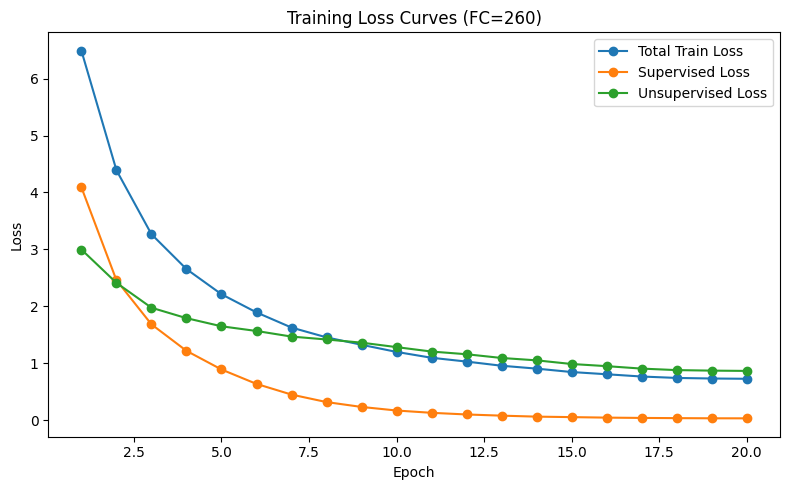

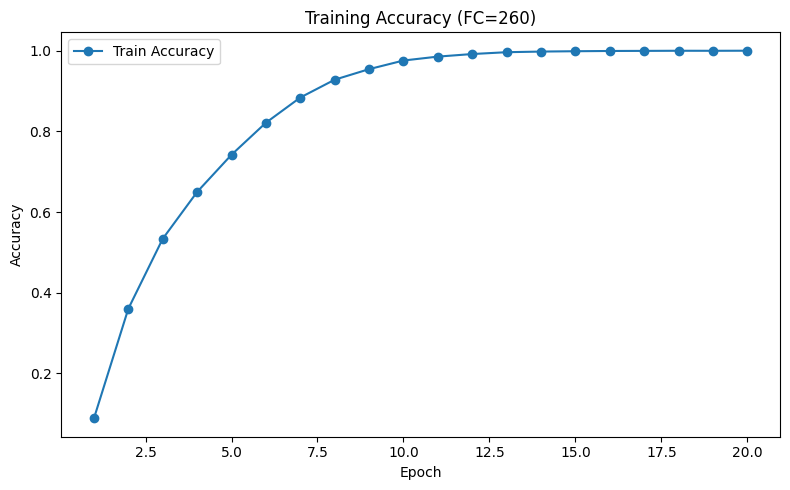

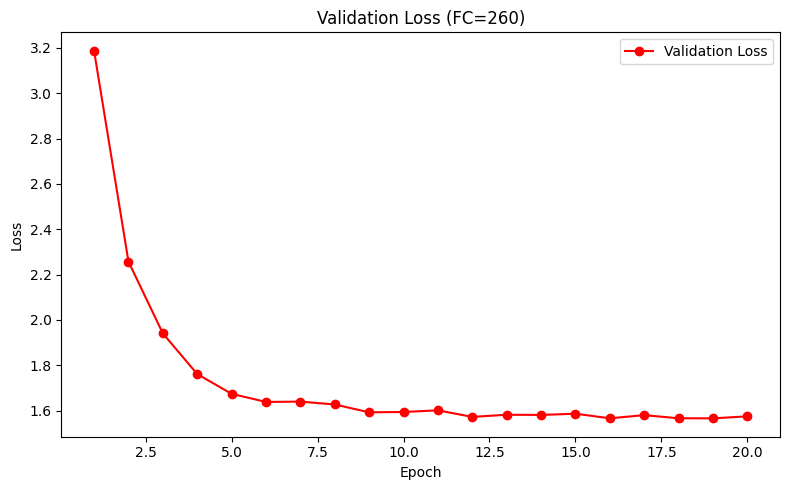

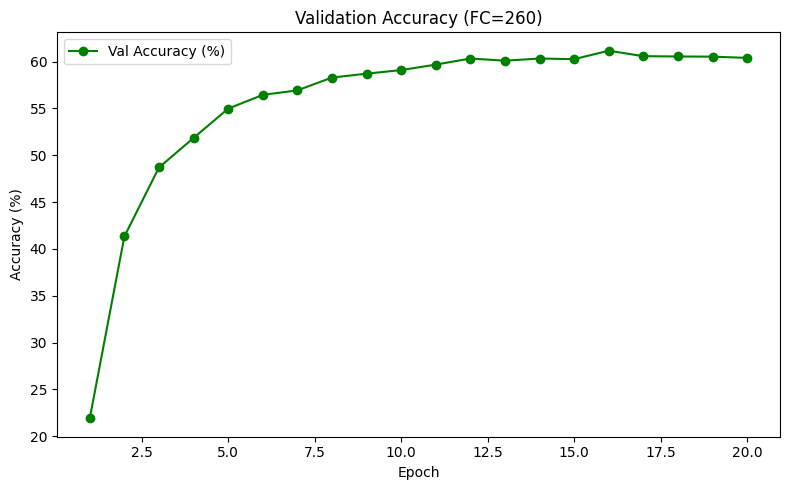

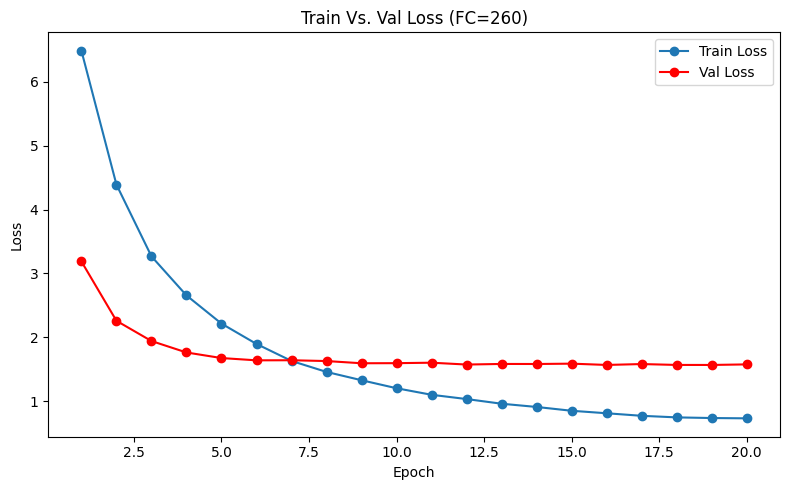

--- Finished plotting for 260 labeled/class ---

=== Running SequenceMatch with 360 labeled samples per class ===

[Data Split] Fixed Count: 360 labeled samples per class
Labeled Training Data: 36000 samples
Unlabeled Training Data: 12000 samples
Validation Data: 6000 samples
Test Data:  6000 samples


Epoch[1/20] FC=360 TrainLoss=6.0092, Sup=3.7278, Unsup=2.8516, TrainAcc=15.19% ValLoss=2.5736, ValAcc=33.82%


Epoch[2/20] FC=360 TrainLoss=3.7005, Sup=2.0048, Unsup=2.1196, TrainAcc=45.91% ValLoss=1.9988, ValAcc=46.68%


Epoch[3/20] FC=360 TrainLoss=2.7284, Sup=1.3610, Unsup=1.7092, TrainAcc=61.18% ValLoss=1.6156, ValAcc=55.40%


Epoch[4/20] FC=360 TrainLoss=2.1727, Sup=0.9784, Unsup=1.4930, TrainAcc=71.22% ValLoss=1.5226, ValAcc=58.00%


Epoch[5/20] FC=360 TrainLoss=1.7721, Sup=0.7061, Unsup=1.3325, TrainAcc=79.19% ValLoss=1.4470, ValAcc=60.57%


Epoch[6/20] FC=360 TrainLoss=1.4699, Sup=0.5009, Unsup=1.2113, TrainAcc=85.84% ValLoss=1.4552, ValAcc=61.03%


Epoch[7/20] FC=360 TrainLoss=1.2365, Sup=0.3509, Unsup=1.1070, TrainAcc=90.64% ValLoss=1.4613, ValAcc=60.68%


Epoch[8/20] FC=360 TrainLoss=1.0706, Sup=0.2517, Unsup=1.0236, TrainAcc=94.07% ValLoss=1.4652, ValAcc=61.90%


Epoch[9/20] FC=360 TrainLoss=0.9261, Sup=0.1803, Unsup=0.9322, TrainAcc=96.24% ValLoss=1.4657, ValAcc=61.90%


Epoch[10/20] FC=360 TrainLoss=0.8196, Sup=0.1351, Unsup=0.8556, TrainAcc=97.60% ValLoss=1.4490, ValAcc=63.12%


Epoch[11/20] FC=360 TrainLoss=0.7269, Sup=0.1007, Unsup=0.7828, TrainAcc=98.69% ValLoss=1.4563, ValAcc=63.38%


Epoch[12/20] FC=360 TrainLoss=0.6507, Sup=0.0775, Unsup=0.7165, TrainAcc=99.20% ValLoss=1.4829, ValAcc=62.53%


Epoch[13/20] FC=360 TrainLoss=0.5826, Sup=0.0595, Unsup=0.6539, TrainAcc=99.60% ValLoss=1.4986, ValAcc=62.58%


Epoch[14/20] FC=360 TrainLoss=0.5200, Sup=0.0473, Unsup=0.5910, TrainAcc=99.76% ValLoss=1.4808, ValAcc=63.53%


Epoch[15/20] FC=360 TrainLoss=0.4736, Sup=0.0376, Unsup=0.5449, TrainAcc=99.86% ValLoss=1.4750, ValAcc=63.53%


Epoch[16/20] FC=360 TrainLoss=0.4341, Sup=0.0314, Unsup=0.5033, TrainAcc=99.94% ValLoss=1.4883, ValAcc=63.63%


Epoch[17/20] FC=360 TrainLoss=0.4031, Sup=0.0276, Unsup=0.4693, TrainAcc=99.94% ValLoss=1.4743, ValAcc=63.87%


Epoch[18/20] FC=360 TrainLoss=0.3849, Sup=0.0256, Unsup=0.4492, TrainAcc=99.96% ValLoss=1.4961, ValAcc=63.30%


Epoch[19/20] FC=360 TrainLoss=0.3791, Sup=0.0241, Unsup=0.4437, TrainAcc=99.97% ValLoss=1.4935, ValAcc=63.53%


Epoch[20/20] FC=360 TrainLoss=0.3655, Sup=0.0233, Unsup=0.4278, TrainAcc=99.97% ValLoss=1.4837, ValAcc=63.83%
Saved SequenceMatch model => SequenceMatch_CIFAR100_360_labeled.pth

[Test Evaluation] FC=360 => TestAcc=64.67%, ROC AUC=0.9847, AvgPrecision=0.7010
               precision    recall  f1-score   support

       beaver       0.47      0.27      0.34        60
      dolphin       0.58      0.63      0.61        60
        otter       0.50      0.50      0.50        60
         seal       0.42      0.42      0.42        60
        whale       0.60      0.62      0.61        60
aquarium fish       0.75      0.75      0.75        60
     flatfish       0.63      0.60      0.62        60
          ray       0.73      0.55      0.63        60
        shark       0.52      0.43      0.47        60
        trout       0.61      0.70      0.65        60
       orchid       0.80      0.67      0.73        60
        poppy       0.72      0.63      0.67        60
         rose       0.59 

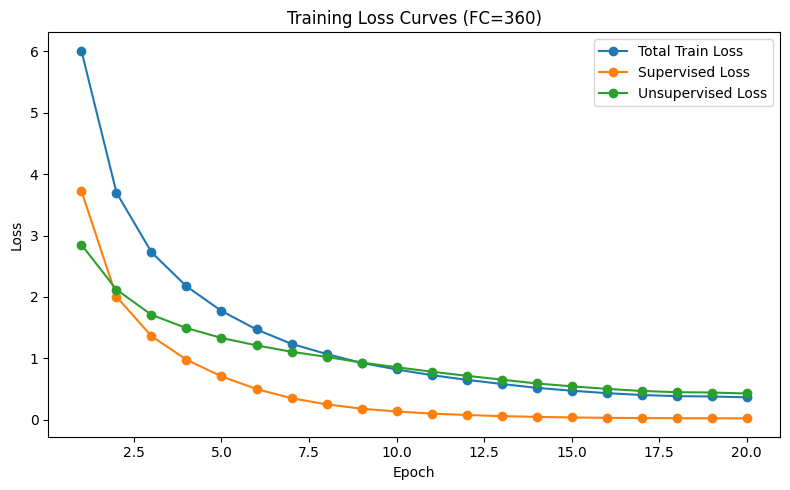

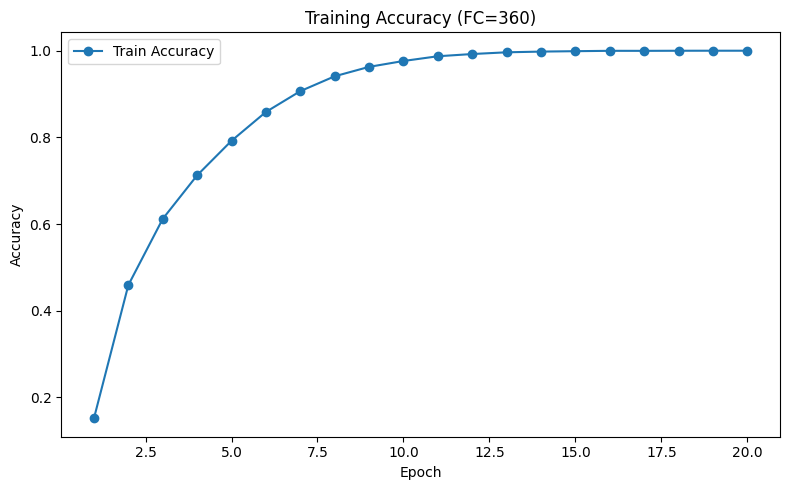

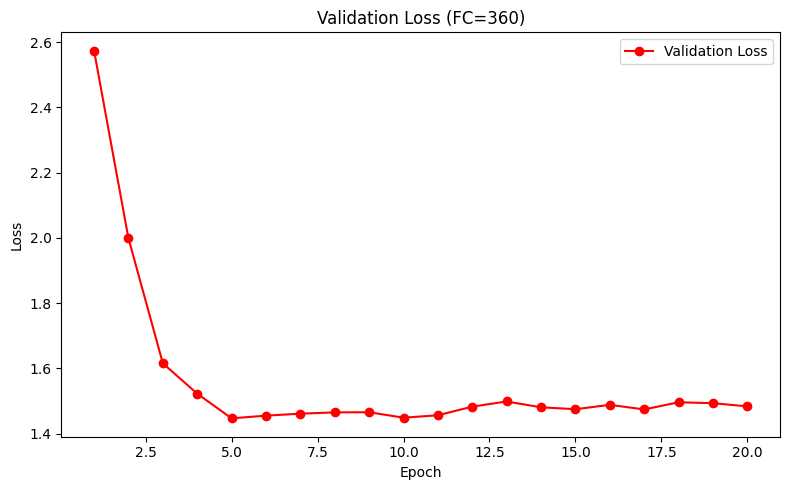

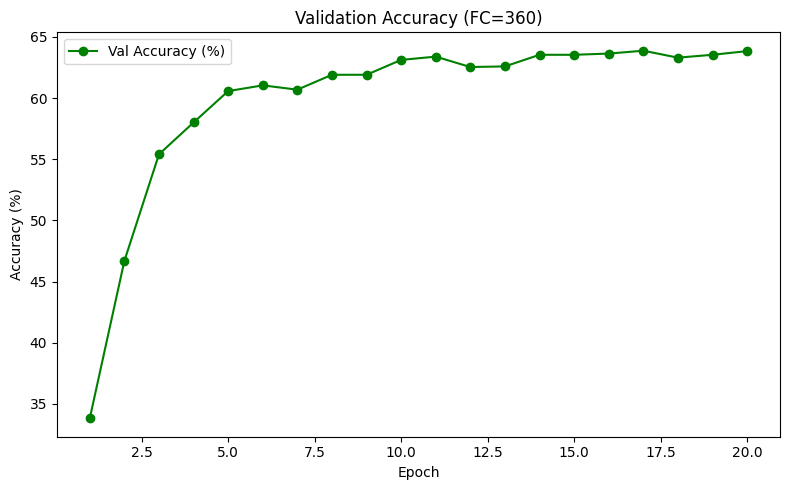

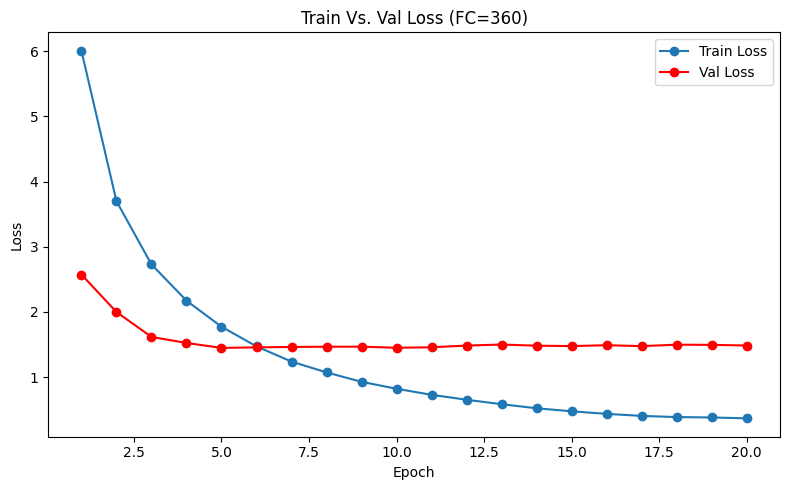

--- Finished plotting for 360 labeled/class ---

[Test Summary] Best run => 360 labeled/class with TestAcc=64.67%


In [ ]:
if __name__ == "__main__":
    from multiprocessing import freeze_support
    freeze_support()
    main()